# Compound vs Substance

## Objectives

- Understand the difference between compounds and substances in PubChem's terminology.
- Learn how chemical structures are represented in a real world.
- Understand the disambiguity of name-structure associations.
- Learn how to draw chemical structures programmatically.

<div class="alert alert-block alert-warning">
Note: To use the python code in this lesson plan, RDKit must be installed on the system. 
</div>

Many users can simply run the following code to install RDKit.

Access to the full installation instructions can be found at the following link.
https://www.rdkit.org/docs/Install.html

## 1. Structure Standardization

PubChem contains more than 200 millions chemical records submitted by hundreds of data contributors.  These depositor-provided records are archived in a database called "**Substance**" and each record in this database is called a **substance**.  The records in the Substance database are highly redundant, because different data contributors may submit information on the same chemical, independently of each other.  Therefore, PubChem extracts unique chemical structures from the Substance database through a process called standardization (https://doi.org/10.1186/s13321-018-0293-8).  These unique structures are stored in the **Compound** database and individaual records in this database is called "**compounds**".  To learn more about the PubChem compounds and substances, please read this PubChem Blog post (https://go.usa.gov/xVXct).

The code cells below demonstrates the effects of chemical structure standardization.

**Step 1.** Download a list of the SIDs associated with a given CID

First, let's get a list of SIDs that are associated CID 1174 (uracil).

In [1]:
import requests

cid = 1174

url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/" + str(cid) + "/sids/txt"
res = requests.get(url)
sids = res.text.split()
print(len(sids))

515


The above request returns 360+ substances, all of which are standardized to the same structure (CID 1174).

**Step 2.** Download the structure data for the SIDs

Now retrieve the depositor-provided structures for the returned substances.  

In [2]:
import time

chunk_size = 50

if len(sids) % chunk_size == 0 :
    num_chunks = int( len(sids) / chunk_size )
else :
    num_chunks = int( len(sids) / chunk_size ) + 1

f = open("cid2sids-uracil.sdf", "w")

for i in range(num_chunks):
    
    print("Processing chunk", i)
    
    idx1 = chunk_size * i
    idx2 = chunk_size * (i + 1)
    str_sids = ",".join(sids[idx1:idx2])
    
    url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/substance/sid/" + str_sids + "/record/sdf"
    res = requests.get(url)

    f.write(res.text)
    time.sleep(0.2)

f.close()

Processing chunk 0
Processing chunk 1
Processing chunk 2
Processing chunk 3
Processing chunk 4
Processing chunk 5
Processing chunk 6
Processing chunk 7
Processing chunk 8
Processing chunk 9
Processing chunk 10


**Step 3.** Convert the structures in the SDF file into the SMILES strings and identify unique SMILES and their frequencies.

In [3]:
from rdkit import Chem

unique_smiles_freq = dict()

suppl = Chem.SDMolSupplier('cid2sids-uracil.sdf')

for mol in suppl:

    smiles = Chem.MolToSmiles(mol,isomericSmiles=True)

    unique_smiles_freq[ smiles ] = unique_smiles_freq.get(smiles,0) + 1

sorted_by_freq = [ (v, k) for k, v in unique_smiles_freq.items() ]
sorted_by_freq.sort(reverse=True)
for v, k in sorted_by_freq :
    print(v, k)

349 O=c1cc[nH]c(=O)[nH]1
105 Oc1ccnc(O)n1
35 
9 O=c1ccnc(O)[nH]1
6 O=c1nccc(O)[nH]1
6 O=c1nc(O)cc[nH]1
5 O=c1cc[nH]c(O)n1


The above output shows that the 360+ SIDs associated with CID 1174 are represented with six different SMILES strings.  In addition, 12 substance records that resulted in an "empty" SMILES strings, implying that the depositors of these substance records did not provide structral information.  You may want to what these 12 substances are, but the above code cell does not tell you what they are.  This can be done using the following code cell.

In [4]:
output_lines = []

for mol in suppl:
    smiles = Chem.MolToSmiles(mol, isomericSmiles=True)
    if smiles == "":
        sid = mol.GetProp("PUBCHEM_SUBSTANCE_ID")
        auto = mol.GetProp("PUBCHEM_SUBS_AUTO_STRUCTURE")
        output_lines.append(f"{sid} : {auto}")

output_lines

['50608295 : Deposited Substance chemical structure was generated via Synonym "CID1174" to be CID 1174',
 '76715622 : Deposited Substance chemical structure was generated via Synonym(s) "uracil" and MeSH to be CID 1174',
 '131322919 : Deposited Substance chemical structure was generated via Synonym(s) "66-22-8", "1,2,3,4-tetrahydropyrimidine-2,4-dione", "MFCD00006016" and Synonym Consistency to be CID 1174',
 '254761593 : Deposited Substance chemical structure was generated via Synonym(s) "uracil" and MeSH to be CID 1174',
 '313082517 : Deposited Substance chemical structure was generated via Synonym(s) "uracil" and MeSH to be CID 1174',
 '329735657 : Deposited Substance chemical structure was generated via Synonym(s) "66-22-8" and Synonym Consistency to be CID 1174',
 '330000149 : Deposited Substance chemical structure was generated via Synonym(s) "uracil" and MeSH to be CID 1174',
 '375972167 : Deposited Substance chemical structure was generated via Synonym(s) "66255-05-8" and Synon

Sometimes a data depositor does not provide the structure of a chemical but its chemical synonym(s).  In that case, PubChem uses the chemical synonyms to assign a structure to this structure-less record.  For example, SID 50608295 (one of the 12 structures without SMILES strings in the above output) did not have a depositor-provided structure, but its depositor-provided synonyms include "CID1174".  Therefore, PubChem assigns SID 50608295 to CID 1174, although the depositor did not provide the structure of SID 50608295.  (Please check the structure and synonyms for SID 50608295 stored in the SDF file ("cid2sids-uracil.sdf") generated in step 2).

**Step 4.** Generate the structure images from the SMILES

Now we want to see what these SMILES strings look like, by drawing molecular structures from them.

O=c1cc[nH]c(=O)[nH]1


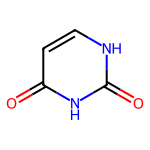

Oc1ccnc(O)n1


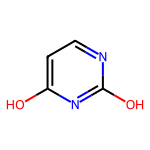

O=c1nc(O)cc[nH]1


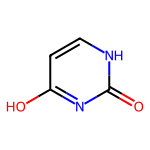

O=c1nccc(O)[nH]1


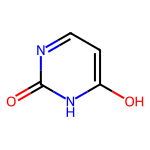

O=c1ccnc(O)[nH]1


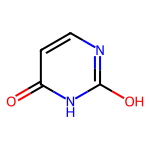

O=c1cc[nH]c(O)n1


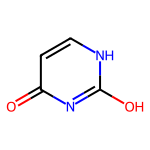

In [5]:
from rdkit.Chem import Draw

for mysmiles in unique_smiles_freq.keys() :

    if mysmiles != "" :
        
        print(mysmiles)
        img = Draw.MolToImage( Chem.MolFromSmiles(mysmiles), size=(150, 150) )
        display(img)

You may want to write these molecule images in files, rather than displaying them on this Jupyter notebook.

In [6]:
from rdkit.Chem import Draw

index = 1

for mysmiles in unique_smiles_freq.keys() :

    if mysmiles != "" :
        
        filename = 'image' + str(index) +'.png'
        Draw.MolToFile( Chem.MolFromSmiles(mysmiles), filename )
        index += 1

You may also want to display all the images in a single figure.

In [7]:
from PIL import Image

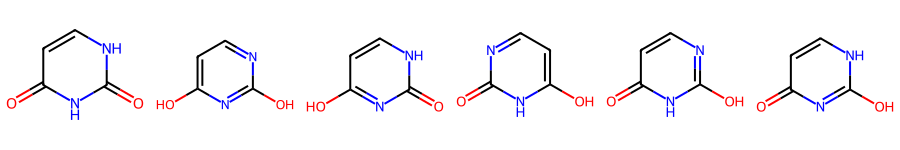

In [8]:
images = []

for mysmiles in unique_smiles_freq.keys() :

    if mysmiles != "" :
        
        img = Draw.MolToImage( Chem.MolFromSmiles(mysmiles), size=(150, 150) )
        images.append(img)

big_img = Image.new('RGB', (900,150))  # enought to arrange six 150x150 images

for i in range(0,len(images)):

    #paste the image at location i,j:
    big_img.paste(images[i], (i*150, 0 ) )

display(big_img)

In [9]:
big_img.save('image_grid.png')

As shown these chemical images, the 360+ substances associated with CID 1174 (uracil) correspond to six tautomeric form of uracil, which differ from each other in the position of "movable" hydrogen atoms.  Compare these structures with their standardized structure (CID 1174).

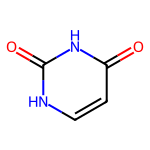

In [10]:
res = requests.get('https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/1174/property/isomericsmiles/txt')
img = Draw.MolToImage( Chem.MolFromSmiles( res.text.rstrip() ), size=(150, 150) )
img

Alternatively, you can get the structure image of CID 1174 from PubChem.

In [11]:
from IPython.display import Image
Image(url='https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/1174/record/PNG?image_size=300x300')

**Exercise 1a:** The **MolToSmiles()** function used in **Step 3** generates the canonical SMILES string by default.  Read the RDKit manual about the arguments available for this function (https://www.rdkit.org/docs/source/rdkit.Chem.rdmolfiles.html) and write a code that generates non-canonical SMILES strings for the 360+ substance records associated with uracil (CID 1174).

- Ignore/skip structure-less records using a conditional statement (i.e., an if statement).
- Print the number of unique non-canonical SMILES.
- Print unique non-canonical SMILES, sorted by frequency.
- For a given molecule, there may be multiple ways to write SMILES strings: one of them is selected as the "canonical" SMILES and all the others are considered as "non-canonical".  However, for the purpose of this exercise, we want to generate only one non-canonical SMILES for each record (because the function will return only one SMILES string (the canonical SMILES or one of possible non-canonical SMILES)).

In [12]:
# Write your code in this cell.




**Exercise 1b:**  The RDKit function "**MolsToGridImage()**" allows you to draw a "grid image" that shows multiple structures.  Read the RDKit manual about "**MolsToGridImage()**" (https://www.rdkit.org/docs/source/rdkit.Chem.Draw.html) and display the structures represented by the unique non-canonical SMILES generated from **Exercise 1a**.  

In [13]:
# Write your code in this cell.





**Exercise 1c:** Retrieve the substance records associated with guanine (CID 135398634) and display unique structures generated from them, by following these steps:

- Retrieve the SIDs associated CID 135398634
- Download the structure data for the retrieved SIDs (in SDF)
- Generate canonical SMILES strings from the structure data in the SDF file and identify unique canonical SMILES strings
- Draw the structures represented by the unqiue canonical SMILES strings in a single figure.

In [14]:
# Write your code in this cell.




**Exercise 1d:** Retrieve the substance records whose synonym is "glucose" and display unique structures generated from them, by following these steps:

- Retrieve the SIDs whose synonym is "glucose".
- Download the structure data for the retrieved SIDs (in SDF)
- Generate canonical SMILES strings from the structure data in the SDF file and identify unique canonical SMILES strings
- Draw the structures represented by the unqiue canonical SMILES strings in a single figure.


In [15]:
# Write your code in this cell.




**Exercise 1e:** Retrieve the compound records associated with the SIDs retrieved in **Exercise 1d** and display unique structures generated from them, by following these steps:

- Retrieve the CIDs associated with the SIDs whose name is "glucose", using a single PUG-REST request (i.e., using the list conversion covered in the previous notebook, "lecture03-list-conversion.ipynb").
- Identify unique CIDs from the returned CIDs, using the **set()** function in python.
- Retrieve the isomeric SMILES for the unique CIDs through PUG-REST.
- Draw the structures represented by the returned SMILES strings in a single figure.

In [16]:
# Write your code in this cell.


